In [34]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from glob import glob 

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.map_coordinates.html

import scipy 
from scipy import ndimage


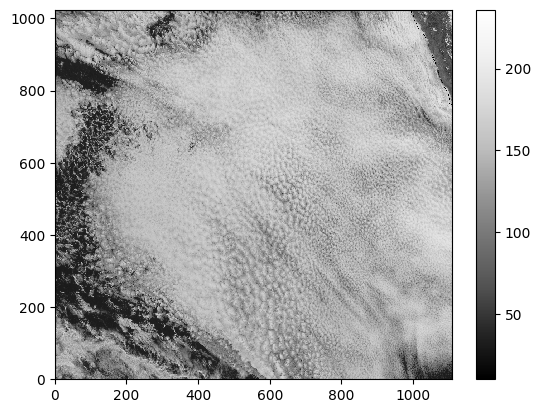

In [35]:


# Define the path to the directory containing the images
path = 'C:\\Users\\ratynski\\Documents\\Python_Projects\\stratocu_waves-main\\DATA\\2022_09_06\\'
# Use glob to find the images in the specified path
fnames = np.sort(glob(path + '*9_06*png'))
images = []

# Read the images and process them
for i, fname in enumerate(fnames):
    img = imageio.v2.imread(fname)
    red = np.flipud(img[:, 400:, 0])
    images.append(red)  # Just red channel, just 400:end in the x dir, flip y

# Plot the first processed image
plt.pcolormesh(images[0], cmap='Greys_r')
plt.colorbar()
plt.show()


In [36]:
# Get the dimensions of the image
height, width = red.shape[:2]

# Create 2D arrays of x and y
x = np.arange(width)
y = np.arange(height)

# Create a meshgrid of x and y
X, Y = np.meshgrid(x, y)


# Pixel size: nominal for MKS units to pixel units 
DX = 2000             # m, pixel size (nominal)

# Xm and Ym are Coordinates in meters, distances measured from central point of image
Xm = (X-X.mean())*DX
Ym = (Y-Y.mean())*DX 

## Wave parameters for warping and modulating an image
"In one period, 7–9 October 2008, the waves modulated cloud-top-height by up to 400 m peak-to-trough, propagating perpendicular to the synoptic boundary layer flow with phase speed 15.3 m s−1, period ∼1 h and horizontal wavelength 55 km. The gravity waves were observed to be non-dispersive. “ from https://doi.org/10.1002/qj.1952

For a wave moving toward 45 degrees (northeast), define k and l as positive (sin and cos of nav angle). Let's take z = sin( k(x-ct) + l(y-ct) ) which is indeed moving NEward with time. Then u and v are both positive at z crests (sketch it). That means dx and dy are positve when time is 1/4 period later, or when 90deg of phase have been subtracted since t appears with a negative sign in the formula for phase (x-ct).

In [37]:
# One wave packet 
cphase = 14            # m/s
wavelength = 150*1000. # meters
period = wavelength/cphase 
direction = 225       # navigation angle of FROM direction in degrees (225 = FROM SW, toward NE) 
zamplitude = 100      # meters, vertical displacement
PBLdepth = 1000       # m, divergent winds assumed to be constant through this layer  

# Wavenumbers computed from wavelengths and direction, units radians per meter
k = 2*np.pi/wavelength * np.sin( (direction) *np.pi/180 )   
l = 2*np.pi/wavelength * np.cos( (direction) *np.pi/180 )   

# Amplitude modulation by a big smooth Gaussian 
packet_center_x = -400*1000  # meters, from middle of Xm, Ym coordinates  
packet_center_y = 400*1000   # meters, from middle of Xm, Ym coordinates  
packet_width_x  = 400*1000.  # meters
packet_width_y  = 300*1000.  # meters
Ampwindow = np.exp(-( ((Xm-packet_center_x)/packet_width_x)**2 + \
                      ((Ym-packet_center_y)/packet_width_y)**2 )) 
     
#plt.pcolormesh(Ampwindow); plt.colorbar()

In [38]:
# A second wave packet 
cphase2 = 20            # m/s
wavelength2 = 100*1000. # meters
period2 = wavelength2/cphase2 
direction2 = 140       # navigation angle of FROM direction in degrees (225 = FROM SW, toward NE) 
zamplitude2 = 50      # meters, vertical displacement
PBLdepth2 = 1000       # m, divergent winds assumed to be constant through this layer  

# Wavenumbers computed from wavelengths and direction, units radians per meter
k2 = 2*np.pi/wavelength2 * np.sin( (direction2) *np.pi/180 )   
l2 = 2*np.pi/wavelength2 * np.cos( (direction2) *np.pi/180 )   

# Amplitude modulation by a big smooth Gaussian 
packet_center_x2 = 400*1000  # meters, from middle of Xm, Ym coordinates  
packet_center_y2 = 100*1000   # meters, from middle of Xm, Ym coordinates  
packet_width_x2  = 200*1000.  # meters
packet_width_y2  = 600*1000.  # meters
Ampwindow2 = np.exp(-( ((Xm-packet_center_x2)/packet_width_x2)**2 + \
                      ( (Ym-packet_center_y2)/packet_width_y2)**2 )) 

### Animation displays for time-dependent warped imagery texture

In [39]:
# Constants for this animation 
time_steps = 10            # Number of time steps 
time_resolution = 1800     # seconds, images are half an hour apart

# The resulting image arrays, for animation 
grid = np.zeros((height, width, time_steps))


# BUILD THE WARPED MODULATED IMAGES AT EACH TIME

for it in range(time_steps):
    t = it*time_resolution     # t is in seconds 

# dz measures vertical displacements: let's choose the sine function. Two packets 
    dz = zamplitude \
         * np.sin( k*(Xm - cphase*t)+l*(Ym - cphase*t) ) *Ampwindow 
    dz2 = zamplitude2 \
         * np.sin( k2*(Xm - cphase2*t)+l2*(Ym - cphase2*t) ) *Ampwindow2

# wave dx and dy are 90deg behind phase with dz, prop. to wavelength. 
# DIRECTION: For 45deg (wave going NE), k>0,l>0, dx>0,dy>0 (sketch it). 

    dxy = (zamplitude/PBLdepth)*wavelength \
          * np.sin( k*(Xm - cphase*t)+l*(Ym - cphase*t) -np.pi/2.) /DX
    dx = dxy * np.sin(direction *np.pi/180.) *Ampwindow # why /2? because it is too strong. Pixel units?? 
    dy = dxy * np.cos(direction *np.pi/180.) *Ampwindow

    dxy2= (zamplitude2/PBLdepth2)*wavelength2 \
          * np.sin( k2*(Xm - cphase2*t)+l2*(Ym - cphase2*t) -np.pi/2.) /DX
    dx2= dxy2* np.sin(direction2 *np.pi/180.) *Ampwindow2 
    dy2= dxy2* np.cos(direction2 *np.pi/180.) *Ampwindow2

# Warping by transporting pixels in original red image, wrapping (periodic) for now. SUBTRACT dy and dx in argument. 
    grid[:,:,it] = ndimage.map_coordinates(images[it],[Y-dy-dy2, X-dx-dx2])  

# Modulate (multiply) albedo by a wavy pattern (vertical displacements, 
#           make consistent with xmotion and ymotion arrays above) 
    grid[:,:,it] *= (1 + dz /PBLdepth  *5) 
    grid[:,:,it] *= (1 + dz2/PBLdepth2 *5) 

maxvalue = grid.max()
maxvalue

309.58694301653907

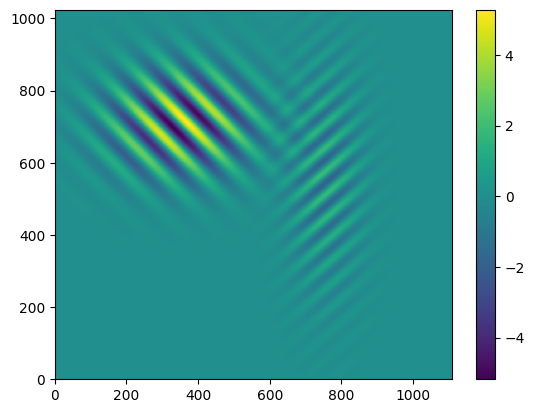

In [40]:
plt.pcolormesh(dy+dy2); plt.colorbar(); # pixels units -- surprising that 7 pixels make such a huge warp?

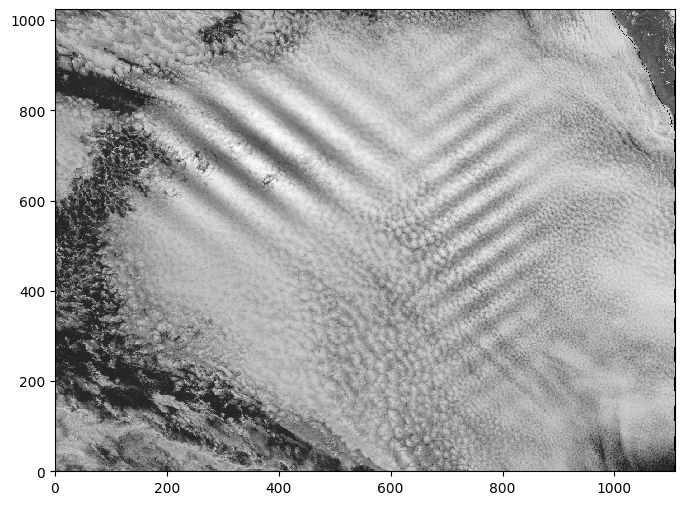

In [41]:
plt.figure(figsize=(8,6))
plt.pcolormesh(grid[:,:,0], cmap='Greys_r')

# Wavelet Image Decomposition

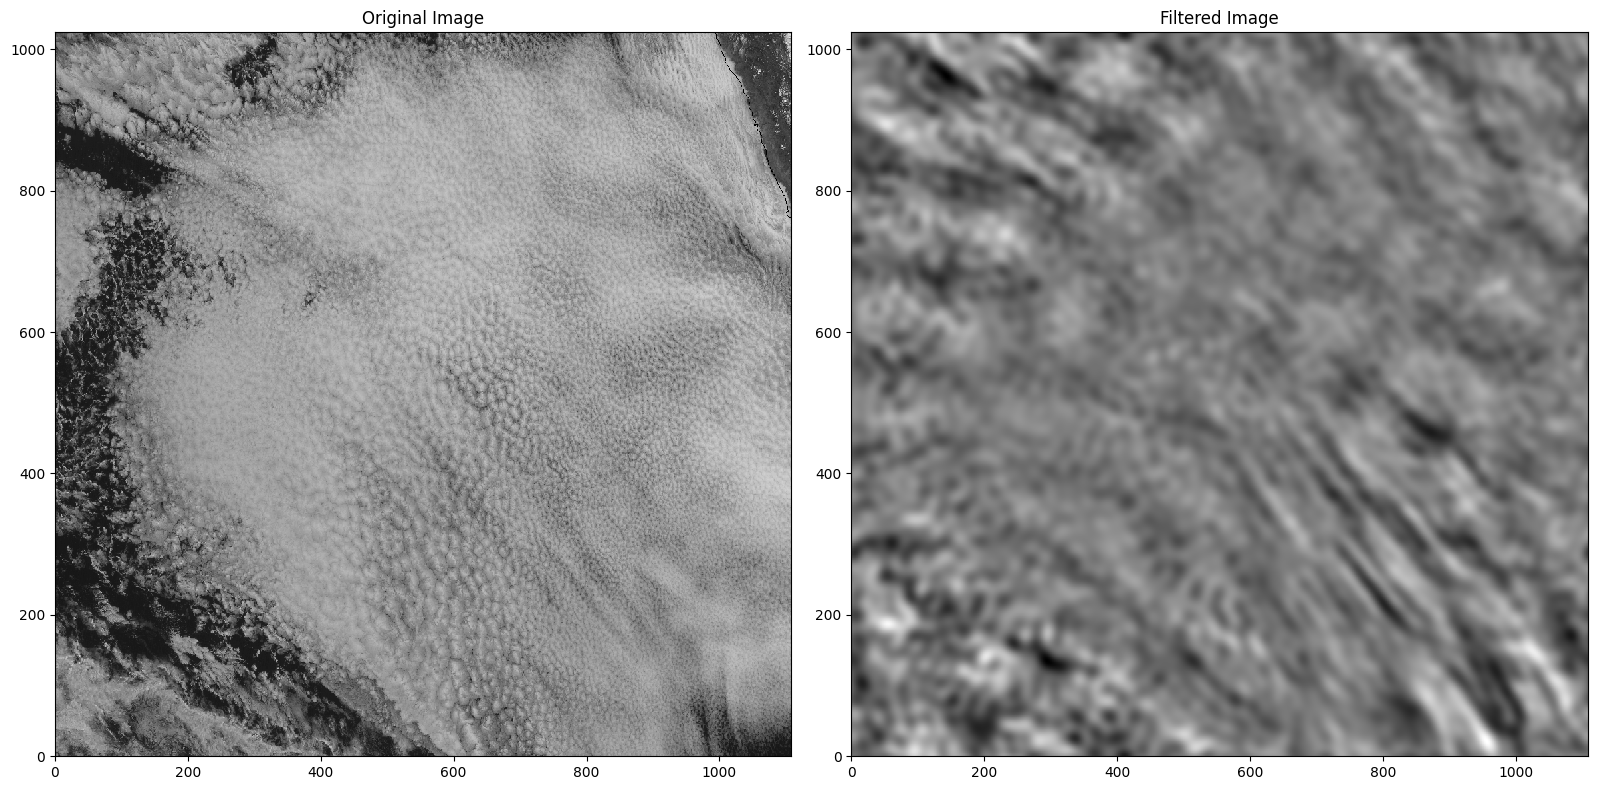

In [42]:
from Eof_functions import filter_frames
from Eof_functions import Visualize_Filter
kl_inf = 0
kl_sup = 1
c_inf = 12
c_sup = 16

# circular permutation of the dimensions until the third one is the time dimension
images = np.moveaxis(images, 2, 0)
images = np.moveaxis(images, 2, 0)

images_filtered = filter_frames(images, kl_inf, kl_sup, c_inf, c_sup)

Visualize_Filter(images,images[0],kl_cutoff_inf=kl_inf,kl_cutoff_sup=kl_sup, c_cutoff_inf=c_inf, c_cutoff_sup=c_sup, Amp=False)

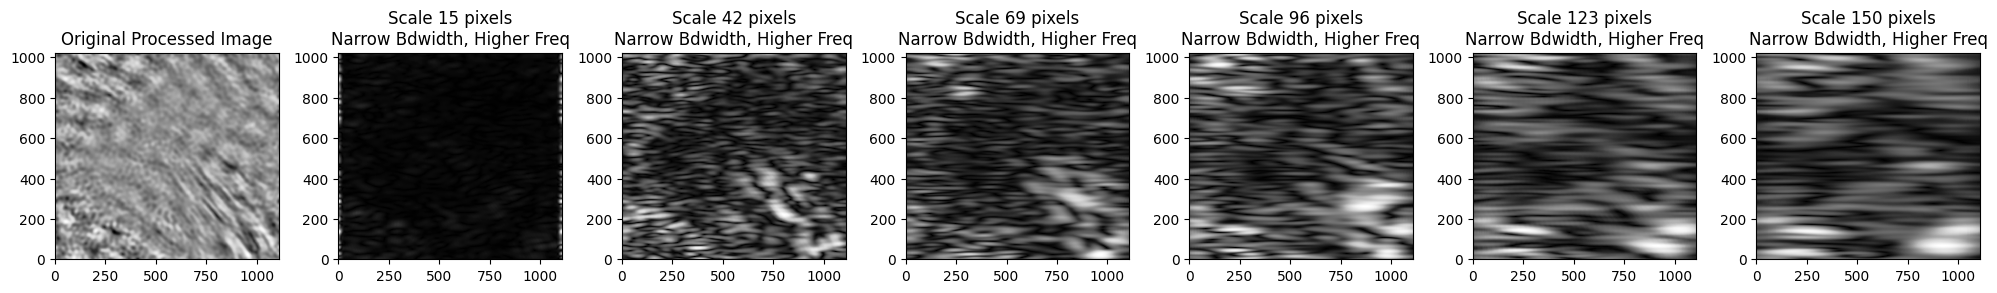

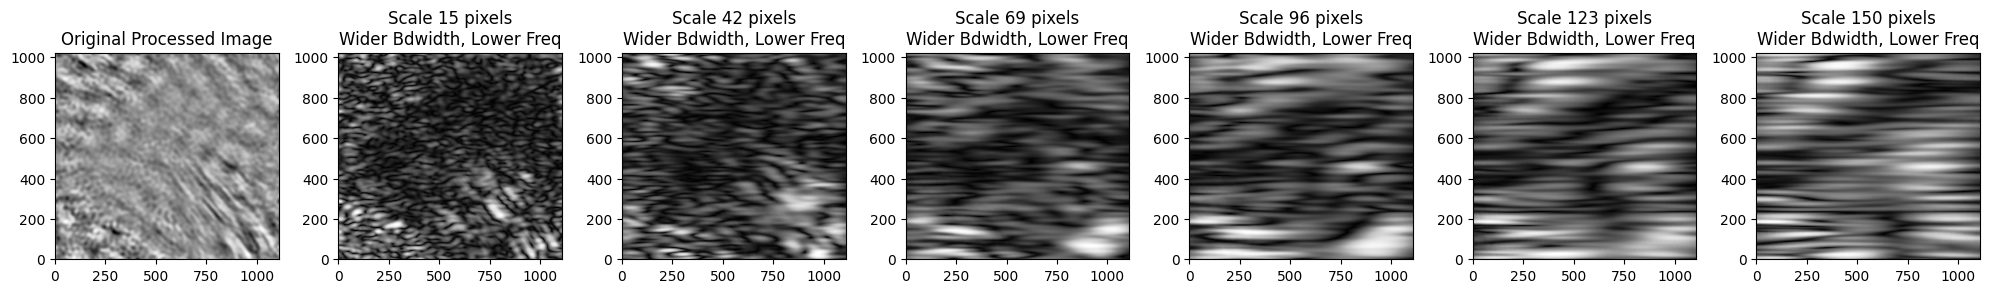

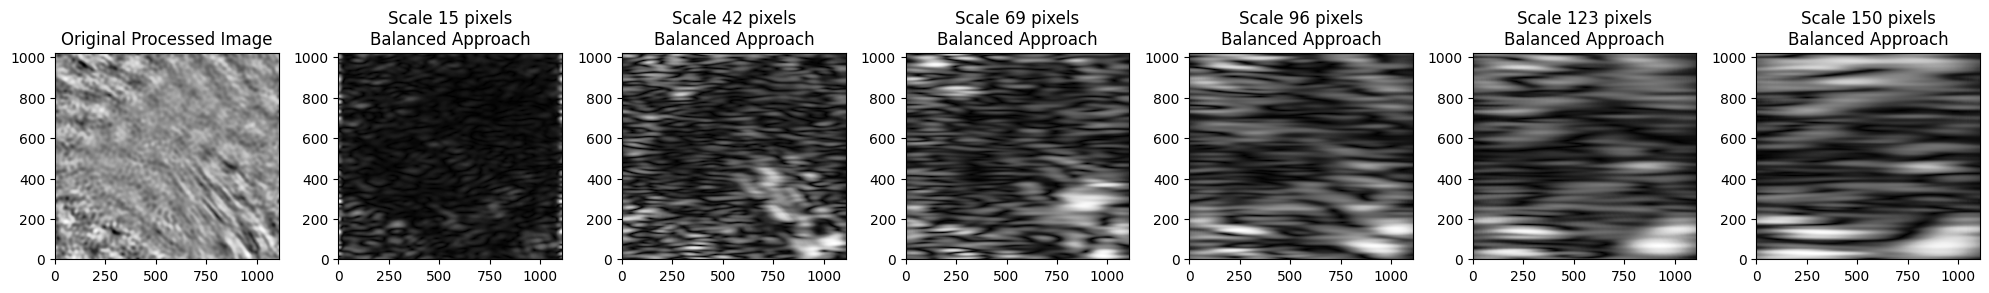

In [43]:
import pywt

# Select the first processed image
image = images_filtered[:,:,0]

# Define the scales for the continuous wavelet transform
# The desired feature sizes are 30 km and 300 km.
# Convert these to pixel scales: 30 km / 2 km/pixel = 15 pixels and 300 km / 2 km/pixel = 150 pixels

# scales = np.arange(15, 151, 15)  # Trying scales from 15 to 150 pixels in steps of 15 pixels
scales = np.arange(15, 151, 27) # Selecting a few representative scales

# Different settings for B and C parameters of the complex Morlet wavelet
wavelet_settings = [
    ('cmor1.0-1.0', 'Narrow Bdwidth, Higher Freq'),
    ('cmor2.0-0.5', 'Wider Bdwidth, Lower Freq'),
    ('cmor1.5-0.8', 'Balanced Approach')
]

for wavelet_name, description in wavelet_settings:
    wavelet = pywt.ContinuousWavelet(wavelet_name)

    fig, axes = plt.subplots(1, len(scales) + 1, figsize=(20, 5))

    # Plot the original processed image
    axes[0].pcolormesh(image, cmap='Greys_r')
    axes[0].set_title('Original Processed Image')
    axes[0].set_aspect('equal')

    # Apply the continuous wavelet transform (CWT) with the complex Morlet wavelet for different scales
    for i, scale in enumerate(scales):
        coefficients, frequencies = pywt.cwt(image, [scale], wavelet)
        magnitude = np.abs(coefficients[0])  # Take the magnitude of the complex coefficients
        axes[i + 1].pcolormesh(magnitude, cmap='Greys_r')
        axes[i + 1].set_title(f'Scale {scale} pixels\n{description}')
        axes[i + 1].set_aspect('equal')

    plt.tight_layout()
    plt.show()

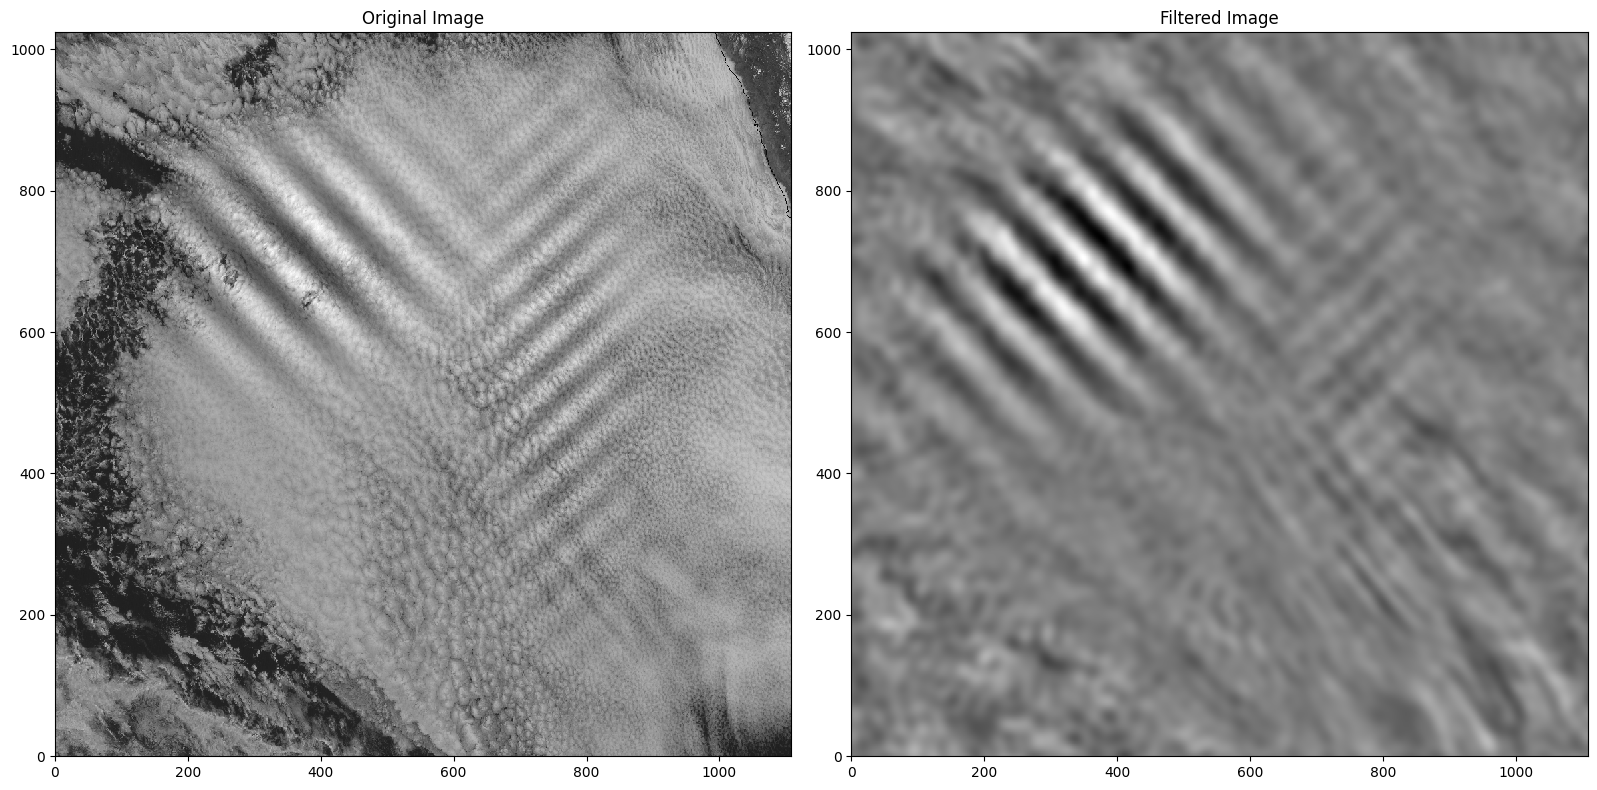

In [44]:
from Eof_functions import filter_frames
from Eof_functions import Visualize_Filter
kl_inf = 0
kl_sup = 1
c_inf = 12
c_sup = 16

images_filtered = filter_frames(grid, kl_inf, kl_sup, c_inf, c_sup)

Visualize_Filter(grid,grid[0],kl_cutoff_inf=kl_inf,kl_cutoff_sup=kl_sup, c_cutoff_inf=c_inf, c_cutoff_sup=c_sup, Amp=False)

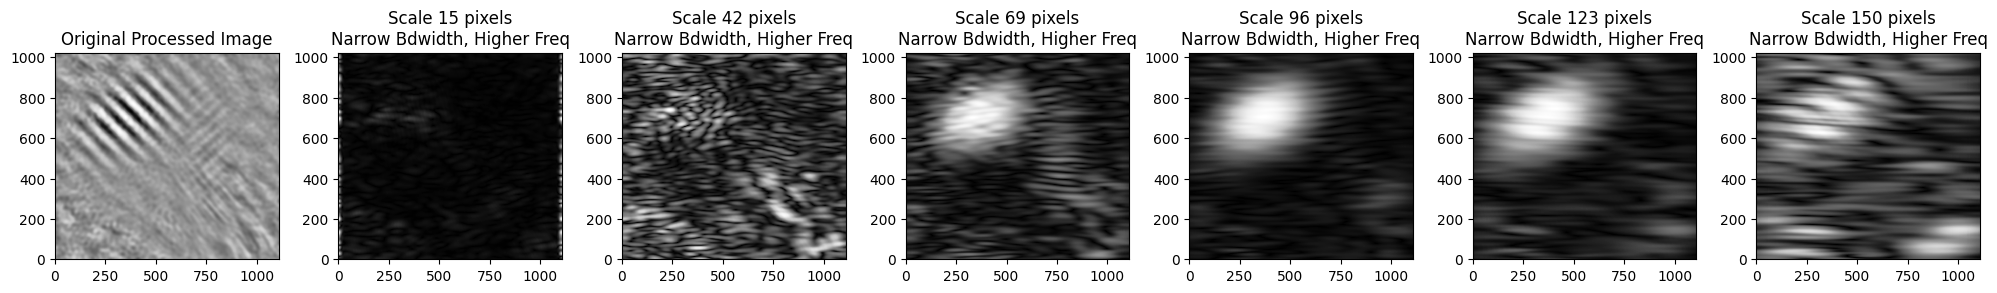

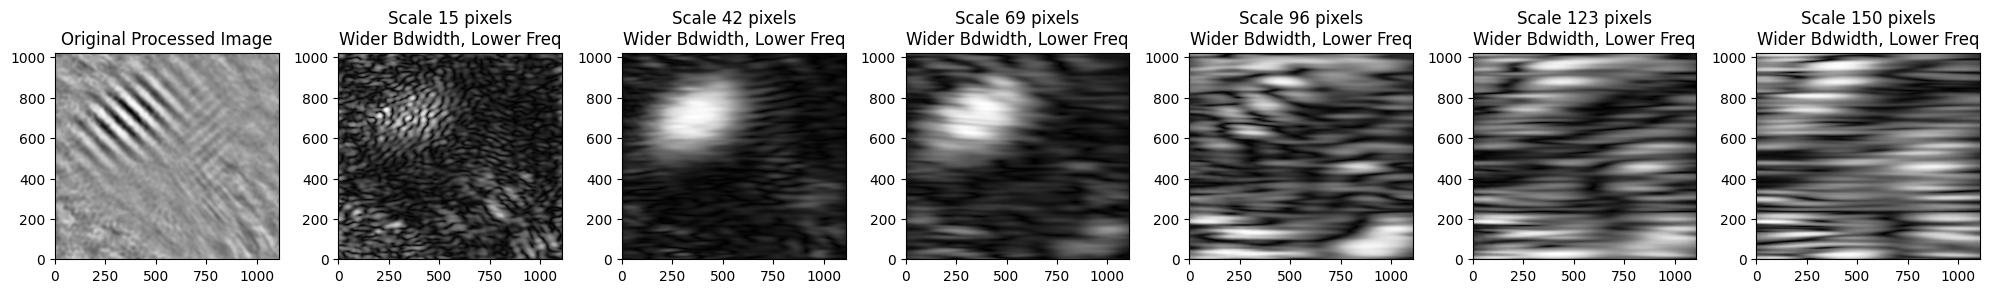

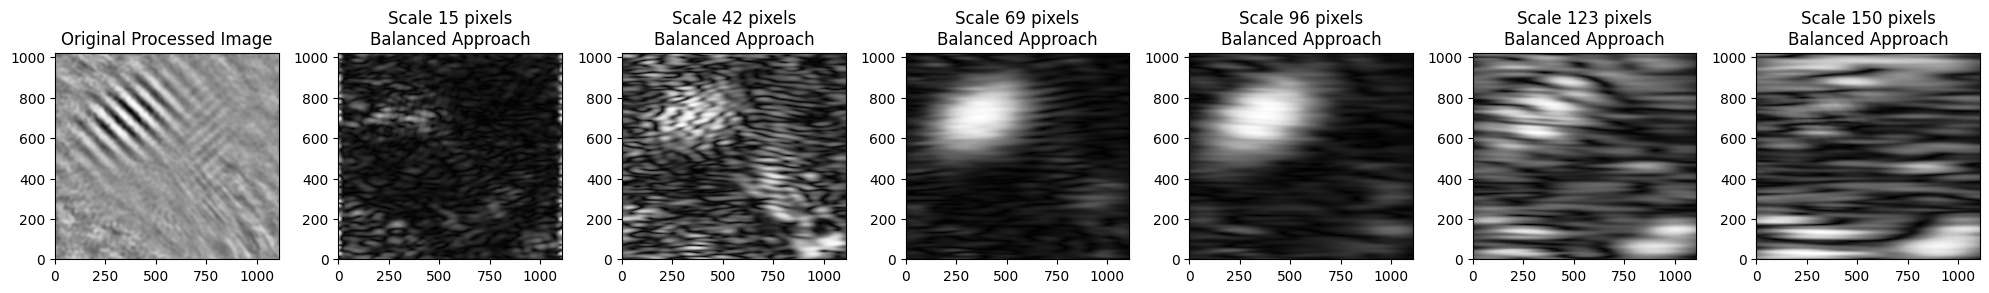

In [45]:
import pywt

# Select the first processed image
image = images_filtered[:,:,0]

# Define the scales for the continuous wavelet transform
# The desired feature sizes are 30 km and 300 km.
# Convert these to pixel scales: 30 km / 2 km/pixel = 15 pixels and 300 km / 2 km/pixel = 150 pixels

# scales = np.arange(15, 151, 15)  # Trying scales from 15 to 150 pixels in steps of 15 pixels
scales = np.arange(15, 151, 27) # Selecting a few representative scales

# Different settings for B and C parameters of the complex Morlet wavelet
wavelet_settings = [
    ('cmor1.0-1.0', 'Narrow Bdwidth, Higher Freq'),
    ('cmor2.0-0.5', 'Wider Bdwidth, Lower Freq'),
    ('cmor1.5-0.8', 'Balanced Approach')
]

for wavelet_name, description in wavelet_settings:
    wavelet = pywt.ContinuousWavelet(wavelet_name)

    fig, axes = plt.subplots(1, len(scales) + 1, figsize=(20, 5))

    # Plot the original processed image
    axes[0].pcolormesh(image, cmap='Greys_r')
    axes[0].set_title('Original Processed Image')
    axes[0].set_aspect('equal')

    # Apply the continuous wavelet transform (CWT) with the complex Morlet wavelet for different scales
    for i, scale in enumerate(scales):
        coefficients, frequencies = pywt.cwt(image, [scale], wavelet)
        magnitude = np.abs(coefficients[0])  # Take the magnitude of the complex coefficients
        axes[i + 1].pcolormesh(magnitude, cmap='Greys_r')
        axes[i + 1].set_title(f'Scale {scale} pixels\n{description}')
        axes[i + 1].set_aspect('equal')

    plt.tight_layout()
    plt.show()